# Code to attempt to use the rechunker package

The zarr arrays were created using the scripts in `../makezarr/*.py` 

In [2]:
import xarray as xr
import zarr
import rechunker
import numpy as np

In [2]:
#Load the data using the zarr arrays:
datadir = '/scratch/tidaldrift/hycom_zarr/'
d1 = xr.open_zarr(datadir + 'hycom12-001.zarr',consolidated=False)
d1

<xarray.Dataset>
Dimensions:    (Depth: 2, Y: 7055, X: 9000, time: 455)
Coordinates:
  * Depth      (Depth) float32 0.0 15.0
  * X          (X) int32 1 2 3 4 5 6 7 8 ... 8994 8995 8996 8997 8998 8999 9000
  * Y          (Y) int32 1 2 3 4 5 6 7 8 ... 7049 7050 7051 7052 7053 7054 7055
  * time       (time) datetime64[ns] 2014-01-01T01:00:28.800000 ... 2014-01-1...
Data variables:
    Latitude   (Y, X) float32 dask.array<chunksize=(7055, 9000), meta=np.ndarray>
    Longitude  (Y, X) float32 dask.array<chunksize=(7055, 9000), meta=np.ndarray>
    u          (time, Depth, Y, X) float32 dask.array<chunksize=(1, 2, 7055, 9000), meta=np.ndarray>
    v          (time, Depth, Y, X) float32 dask.array<chunksize=(1, 2, 7055, 9000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0
    experiment:   10.2
    history:      archv2ncdf3z
    source:       HYCOM archive file
    title:        HYCOM

In [3]:
d1.u.data

,Array,Chunk
Bytes,215.25 GiB,484.43 MiB
Shape,"(455, 2, 7055, 9000)","(1, 2, 7055, 9000)"
Count,2 Graph Layers,455 Chunks
Type,float32,numpy.ndarray


In [4]:
source_group = zarr.open('/scratch/tidaldrift/hycom_zarr/hycom12-001.zarr')
print(source_group.tree())

/
 ├── Depth (2,) float32
 ├── Latitude (7055, 9000) float32
 ├── Longitude (7055, 9000) float32
 ├── X (9000,) int32
 ├── Y (7055,) int32
 ├── time (455,) float64
 ├── u (455, 2, 7055, 9000) float32
 └── v (455, 2, 7055, 9000) float32


In [5]:
source_array = source_group
source_array.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,8
No. arrays,8
No. groups,0
Arrays,"Depth, Latitude, Longitude, X, Y, time, u, v"


In [6]:
target_chunks = {
    'u': {'time': 455 ,'Depth' : 1, 'Y': 1, 'X': 9000},
    'v': {'time': 455 ,'Depth' : 1, 'Y': 1, 'X': 9000}, 
    'Longitude': {'Y': 7055, 'X': 9000}, 
    'Latitude': {'Y': 7055, 'X': 9000},     
    'time': None,
    'X': None,
    'Y': None,
    'Depth': None,
}
max_mem = '1000MB'

In [7]:
# make sure the target and temp store do not already exist!
!rm -rf /scratch/tidaldrift/hycom_zarr/hycom12-001_u_rechunked-tmp.zarr /scratch/tidaldrift/hycom_zarr/hycom12-001_u_rechunked.zarr
target_store = '/scratch/tidaldrift/hycom_zarr/hycom12-001_u_rechunked.zarr'
temp_store = '/scratch/tidaldrift/hycom_zarr/hycom12-001_u_rechunked-tmp.zarr'
array_plan = rechunker.rechunk(source_array, target_chunks, max_mem, target_store, temp_store=temp_store)
array_plan

<Rechunked>
* Source      : <zarr.hierarchy.Group '/'>

* Intermediate: <zarr.hierarchy.Group '/'>

* Target      : <zarr.hierarchy.Group '/'>

In [3]:
from dask.distributed import Client, LocalCluster, progress

cluster = LocalCluster()
client = Client(cluster)

2022-12-17 16:34:27,890 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ab5fc3ri', purging
2022-12-17 16:34:27,890 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ux4n7_w0', purging
2022-12-17 16:34:27,891 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-iif4or8n', purging
2022-12-17 16:34:27,891 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-1qj5gaci', purging
2022-12-17 16:34:27,891 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-8ys4c17u', purging
2022-12-17 16:34:27,891 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-c0xvherz', purging
2022-12-17 16:34:27,892 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-y0vkzipo', purging

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 160,Total memory: 283.06 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37301,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 160
Started: Just now,Total memory: 283.06 GiB
Comm: tcp://127.0.0.1:33251,Total threads: 10
Dashboard: http://127.0.0.1:35907/status,Memory: 17.69 GiB
Nanny: tcp://127.0.0.1:43503,


In [10]:
# from dask.diagnostics import ProgressBar
# with ProgressBar():
#     array_plan.execute()
array_plan.execute()

/home/selipot/miniconda3/envs/research/lib/python3.10/site-packages/distributed/worker.py:2938: UserWarning: Large object of size 7.24 MiB detected in task graph: 
  ("('copy_read_to_intermediate-6591c8c29866c6318c2e ... eeab', 65146)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
2022-12-16 18:13:36,007 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x2001fd7536d0>>
Traceback (most recent call last):
  File "/home/selipot/miniconda3/envs/research/lib/python3.10/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/home/selipot/miniconda3/envs/research/lib/python3.10/site-packages/bokeh/server/tornado.py", line 

<zarr.hierarchy.Group '/'>

In [5]:
d1r = zarr.open('/scratch/tidaldrift/hycom_zarr/hycom12-001_u_rechunked.zarr')

In [6]:
d1r.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,8
No. arrays,8
No. groups,0
Arrays,"Depth, Latitude, Longitude, X, Y, time, u, v"


In [7]:
print(d1r.tree())

/
 ├── Depth (2,) float32
 ├── Latitude (7055, 9000) float32
 ├── Longitude (7055, 9000) float32
 ├── X (9000,) int32
 ├── Y (7055,) int32
 ├── time (455,) float64
 ├── u (455, 2, 7055, 9000) float32
 └── v (455, 2, 7055, 9000) float32


In [9]:
d1x = xr.open_zarr('/scratch/tidaldrift/hycom_zarr/hycom12-001_u_rechunked.zarr',consolidated=False,decode_coords=True)

In [10]:
d1x

<xarray.Dataset>
Dimensions:    (Depth: 2, Y: 7055, X: 9000, time: 455)
Coordinates:
  * Depth      (Depth) float32 0.0 15.0
  * X          (X) int32 1 2 3 4 5 6 7 8 ... 8994 8995 8996 8997 8998 8999 9000
  * Y          (Y) int32 1 2 3 4 5 6 7 8 ... 7049 7050 7051 7052 7053 7054 7055
  * time       (time) datetime64[ns] 2014-01-01T01:00:28.800000 ... 2014-01-1...
Data variables:
    Latitude   (Y, X) float32 dask.array<chunksize=(7055, 9000), meta=np.ndarray>
    Longitude  (Y, X) float32 dask.array<chunksize=(7055, 9000), meta=np.ndarray>
    u          (time, Depth, Y, X) float32 dask.array<chunksize=(455, 1, 1, 9000), meta=np.ndarray>
    v          (time, Depth, Y, X) float32 dask.array<chunksize=(455, 1, 1, 9000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0
    experiment:   10.2
    history:      archv2ncdf3z
    source:       HYCOM archive file
    title:        HYCOM

In [59]:
a = -1
(a>=d1x.u.valid_range[0] & a<=d1x.u.valid_range[1]).all()

In [60]:
x = np.arange(0,10)
(x<5).any()

True

In [80]:
foo = bool(d1x['u']>d1x.u.valid_range[1])
foo

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [79]:
foo.dims

('X',)

In [74]:
d1x_masked = d1x
d1x_masked["u"].where(foo,np.nan,d1x["u"]) 
d1x_masked

2022-12-17 18:51:56,584 - distributed.worker_memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 15.83 GiB -- Worker memory limit: 17.69 GiB
2022-12-17 18:51:57,679 - distributed.worker_memory - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 16.01 GiB -- Worker memory limit: 17.69 GiB
2022-12-17 18:51:59,159 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:38917 (pid=149247) exceeded 95% memory budget. Restarting...
2022-12-17 18:51:59,544 - distributed.nanny - WARNING - Restarting worker
2022-12-17 18:52:01,256 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:44911 (pid=149221) exceeded 95% memory budget. Restarting...
2022-12-17 18:52:01,597 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:38309 (pid=149232) exceeded 95% memory budget. Restarting...
2022-12-17 18:52:01,633 - distributed.nanny - WARNING - Restarting worker
2022-12-17 18:52:01,930 - distributed.nanny - WARNING - Restarti

KeyboardInterrupt: 

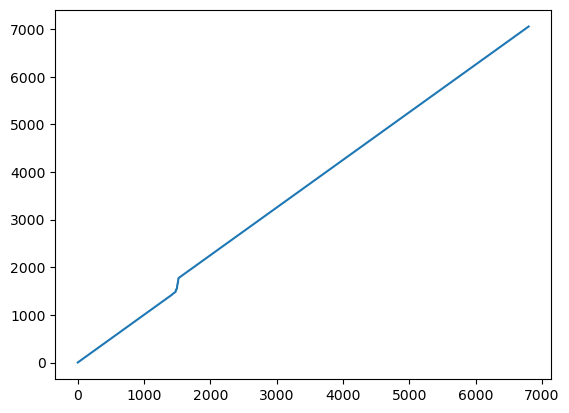

In [72]:
plt.plot(d1x_masked.Y)

In [67]:
foo = d1x_masked.u[:,0,1000,:].mean(dim="time")

In [68]:
foo.compute()

<xarray.DataArray 'u' (X: 9000)>
array([1.2676506e+30, 1.2676506e+30, 1.2676506e+30, ..., 1.2676506e+30,
       1.2676506e+30, 1.2676506e+30], dtype=float32)
Coordinates:
    Depth    float32 0.0
  * X        (X) int32 1 2 3 4 5 6 7 8 ... 8994 8995 8996 8997 8998 8999 9000
    Y        int32 1001

In [69]:
foo2 = d1x.u[:,0,1000,:].mean(dim="time")
foo2.compute()

<xarray.DataArray 'u' (X: 9000)>
array([1.2676506e+30, 1.2676506e+30, 1.2676506e+30, ..., 1.2676506e+30,
       1.2676506e+30, 1.2676506e+30], dtype=float32)
Coordinates:
    Depth    float32 0.0
  * X        (X) int32 1 2 3 4 5 6 7 8 ... 8994 8995 8996 8997 8998 8999 9000
    Y        int32 1001

In [70]:
import matplotlib.pyplot as plt

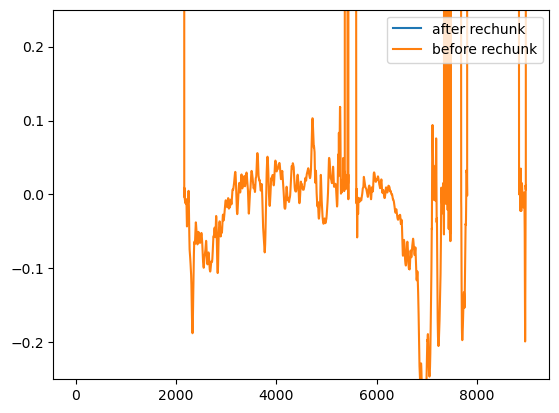

In [71]:
fig, ax = plt.subplots()
ax.plot(foo,label='after rechunk')
ax.plot(foo2,label='before rechunk')
ax.set_ylim([-0.25,0.25])
plt.legend()

In [47]:
d1.u

,Array,Chunk
Bytes,215.25 GiB,484.43 MiB
Shape,"(455, 2, 7055, 9000)","(1, 2, 7055, 9000)"
Count,2 Graph Layers,455 Chunks
Type,float32,numpy.ndarray


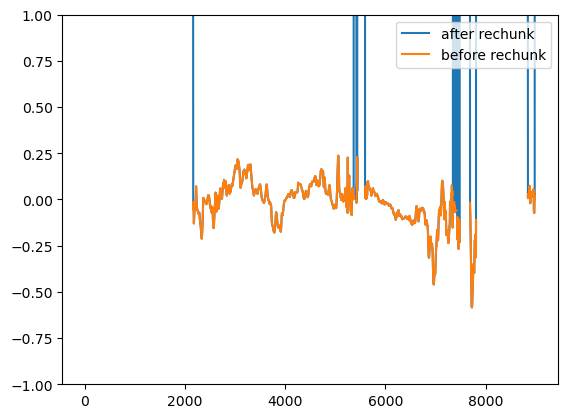

In [52]:
fig, ax = plt.subplots()
ax.plot(d1x.X,d1x.u[0,0,1000,:],label='after rechunk')
ax.plot(d1.X,d1.u[0,0,1000,:],label='before rechunk')
ax.set_ylim([-1,1])
plt.legend()

In [55]:
d1x.u[0,0,1000,0].compute()

<xarray.DataArray 'u' ()>
array(1.2676506e+30, dtype=float32)
Coordinates:
    Depth    float32 0.0
    X        int32 1
    Y        int32 1001
    time     datetime64[ns] 2014-01-01T01:00:28.800000
Attributes:
    coordinates:    Longitude Latitude Date
    long_name:       u-veloc. [10.2H]
    standard_name:  eastward_sea_water_velocity
    units:          m/s
    valid_range:    [-4.149928569793701, 4.774961948394775]

In [56]:
d1.u[0,0,1000,0].compute()

<xarray.DataArray 'u' ()>
array(nan)
Coordinates:
    Depth    float32 0.0
    X        int32 1
    Y        int32 1001
    time     datetime64[ns] 2014-01-01T01:00:28.800000
Attributes:
    coordinates:    Longitude Latitude Date
    long_name:       u-veloc. [10.2H]
    standard_name:  eastward_sea_water_velocity
    units:          m/s
    valid_range:    [-4.149928569793701, 4.774961948394775]

In [60]:
%time mu1 = d1.u[:,0,:,:].mean(dim="time").compute() 

CPU times: user 27min 56s, sys: 12min 55s, total: 40min 52s
Wall time: 38.8 s


In [61]:
%time mu1 = d1x.u[:,0,:,:].mean(dim="time").compute() 

CPU times: user 5min 51s, sys: 28.2 s, total: 6min 19s
Wall time: 28.8 s
